In [1]:
!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import constants
from scipy import signal
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import dblquad
from matplotlib.ticker import MultipleLocator
import pylab
import astropy.units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from scipy.special import gamma as gamma_func
from matplotlib.colors import LogNorm

In [2]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.waveform
from pycbc.types import TimeSeries
from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd import interpolate, inverse_spectrum_truncation
import pylab
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.noise
import pycbc.psd
from pycbc.filter import matched_filter
from pycbc.filter import sigma
from mpmath import mp
from astropy.cosmology import Planck18 as cosmo
from matplotlib.ticker import LogLocator, LogFormatter
from pycbc.psd import welch

/home/rosar/phd/personal/phd/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/home/rosar/phd/personal/phd/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrai

In [3]:
from functools import partial
import multiprocessing
from tqdm import tqdm
from multiprocessing import cpu_count

ncpu = cpu_count()
print(f"{ncpu} CPUs")

20 CPUs


$\Omega$ parameter

In [25]:
def omega (Ml,f):
    solar_mass_kg = 1.9891e30*u.kilogram
    Ml_kg = Ml*solar_mass_kg
    f_Hz = f*u.hertz

    cons = 8*np.pi*G*(c**(-3))
    omega = cons * Ml_kg * f_Hz
    return omega.value


In [26]:
f_range = np.logspace(0,4,100)
m_range = np.logspace (-2,8,100)

m_grid,f_grid = np.meshgrid(f_range,m_range,indexing = 'ij')
omega_grid = omega(m_grid,f_grid)
omega_grid.reshape(m_grid.shape)

array([[1.23834054e-06, 1.56260854e-06, 1.97178834e-06, ...,
        7.77713952e+03, 9.81363703e+03, 1.23834054e+04],
       [1.35907722e-06, 1.71496094e-06, 2.16403527e-06, ...,
        8.53540102e+03, 1.07704545e+04, 1.35907722e+04],
       [1.49158557e-06, 1.88216752e-06, 2.37502604e-06, ...,
        9.36759208e+03, 1.18205605e+04, 1.49158557e+04],
       ...,
       [1.02809207e-02, 1.29730506e-02, 1.63701332e-02, ...,
        6.45671786e+07, 8.14745387e+07, 1.02809207e+08],
       [1.12832978e-02, 1.42379070e-02, 1.79662010e-02, ...,
        7.08623988e+07, 8.94182056e+07, 1.12832978e+08],
       [1.23834054e-02, 1.56260854e-02, 1.97178834e-02, ...,
        7.77713952e+07, 9.81363703e+07, 1.23834054e+08]],
      shape=(100, 100))

<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_17632/3293229257.py:5: SyntaxWarning: invalid escape sequence '\O'
  plt.clabel(contour_line,inline=True,fmt='$\Omega$=1')
/tmp/ipykernel_17632/3293229257.py:4: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour_line = plt.contour(m_grid,f_grid,omega_grid,levels =[1],colors = 'red',linewidth = 2)


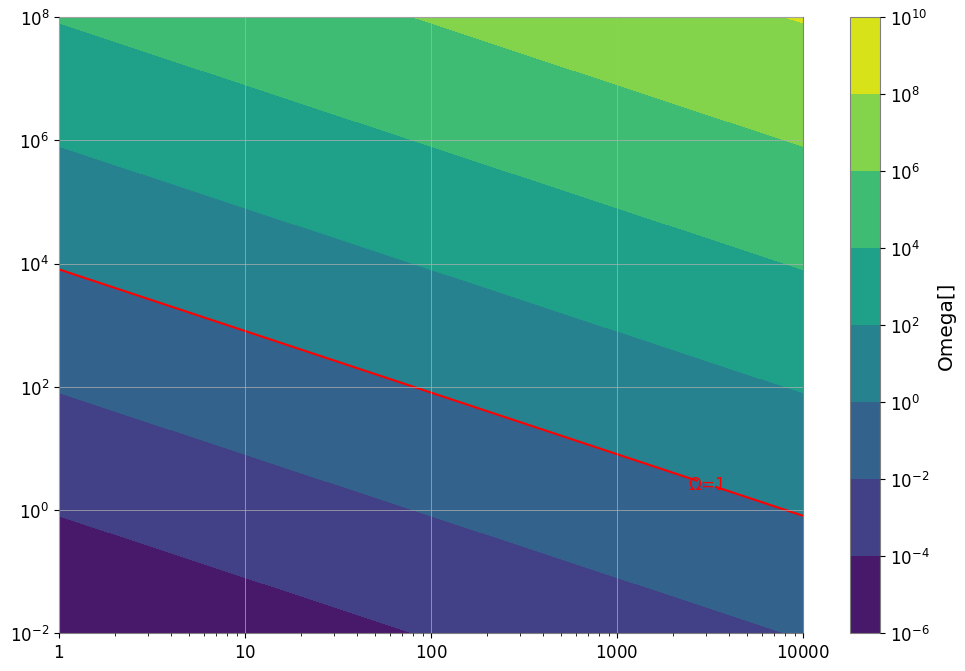

In [32]:
plt.figure(figsize=(12,8))
contour = plt.contourf(m_grid,f_grid,omega_grid,levels = 20,norm = LogNorm())
plt.colorbar(contour,label = 'Omega[]')
contour_line = plt.contour(m_grid,f_grid,omega_grid,levels =[1],colors = 'red',linewidth = 2)
plt.clabel(contour_line,inline=True,fmt='$\Omega$=1')
plt.xscale('log')
plt.yscale('log')

In [45]:
print (omega(10,100))

0.12383405432497571 Hz s


In [5]:
from gwosc import datasets
from gwosc.datasets import run_segment


In [68]:
catalogs = datasets.find_datasets(type='run')
print (catalogs)

['O1', 'O2', 'O3GK', 'O3a', 'O3b', 'O4a', 'O4b3Disc', 'S5', 'S6']


In [6]:
events = datasets.find_datasets(type='events')

In [90]:
print(events)

['151008-v1', '151012.2-v1', '151116-v1', '161202-v1', '161217-v1', '170208-v1', '170219-v1', '170405-v1', '170412-v1', '170423-v1', '170616-v1', '170630-v1', '170705-v1', '170720-v1', '190924_232654-v1', '191118_212859-v1', '191223_014159-v1', '191225_215715-v1', '200114_020818-v1', '200121_031748-v1', '200201_203549-v1', '200214_224526-v1', '200214_224526-v2', '200219_201407-v1', '200311_103121-v1', 'GRB051103-v1', 'GW150914-v1', 'GW150914-v2', 'GW150914-v3', 'GW151012-v1', 'GW151012-v2', 'GW151012-v3', 'GW151226-v1', 'GW151226-v2', 'GW170104-v1', 'GW170104-v2', 'GW170608-v1', 'GW170608-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v1', 'GW170814-v2', 'GW170814-v3', 'GW170817-v1', 'GW170817-v2', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1', 'GW190403_051519-v1', 'GW190408_181802-v1', 'GW190408_181802-v2', 'GW190408_181802-v3', 'GW190412-v1', 'GW190412-v2', 'GW190412-v3', 'GW190412-v5', 'GW190412_053044-v4', 'GW190413_052954-v1', 'GW190413_052954-v2', 'GW190413_052954-v3'

In [91]:
print (len(events))

356


In [7]:
detected_gw = []
for e in events:
    if (len(e) <=11) & (e[0] == 'G'):
        detected_gw.append(e)

In [96]:
print(len(detected_gw))

36


In [102]:
print(detected_gw[0])

GW150914-v1


In [8]:
from gwpy.timeseries import TimeSeries as gwpy_ts
data = gwpy_ts.fetch_open_data('H1',
                                  datasets.event_gps(detected_gw[0]),
                                  datasets.event_gps(detected_gw[0])+16
)

In [ ]:
data.

<TimeSeries([-2.64076922e-19, -2.95929189e-19, -2.94362862e-19,
             ..., -6.44526154e-21, -6.36026905e-21,
             -3.74912730e-20]
            unit=Unit(dimensionless),
            t0=<Quantity 1.12625946e+09 s>,
            dt=<Quantity 0.00024414 s>,
            name='Strain',
            channel=None)>